In [335]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import seaborn as sns
import cPickle

from collections import Counter

from agglomerative import get_data

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import estimate_bandwidth, KMeans, AffinityPropagation,DBSCAN,AgglomerativeClustering,MeanShift
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.mixture import GaussianMixture

%matplotlib inline

In [365]:
# Constants - The master stat (feature) list, and the corresponding player data.
stats_list = ['MP_x','FG','FGA','2P','2PA','3P','3PA','FT','FTA','ORB', 'DRB', 'TRB', 'AST', 'STL','BLK','TOV','PF','PTS','FG%','2P%','3P%', 'eFG%', 'FT%', 'TS%_x', 'PER', '3PAr','FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%','ORtg', 'DRtg', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM','VORP', 'dist', 'spd', 'tchs', 'pass', 'sast', 'ftast', 'dfgm','dfga']
df = pd.read_csv('../data/final_stats.csv')
df.set_index('player_year',inplace=True)
df.fillna(value=0,inplace=True)

In [262]:
# A number of tools we'll use to help us analyze different feature spaces! 
def plot_tsne_scatter(X,filename=None,three_d=False,title=None):
    '''
    Arguments:
    X - Feature matrix X, a dataframe or array of numerical data.
    filename - String, appended to filename of png written to directory img
    three_d - Boolean, if True, function plots and saves 3-d representation of data as well.
    title - String, used as title of plot(s)

    Output:
    None, plots 2d-projection of higher-dimensional data, saves figure to img directory.
    '''
    tsne2d = TSNE(n_components=2,init='pca',random_state=23).fit_transform(X)
    tsne3d = TSNE(n_components=3,init='pca',random_state=23).fit_transform(X)


    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)
    ax1.scatter(tsne2d[:,0],tsne2d[:,1],cmap=plt.cm.Spectral)
    ax1.set_title(title)
    plt.axis('tight')
    plt.show()
    if not filename:
        plt.savefig('../img/2dtsne.png')
    else:
        plt.savefig('../img/2dtsne_{}.png'.format(filename))

    if three_d:
        ax2 = fig.add_subplot(111,projection='3d')
        ax2.scatter(tsne3d[:,0],tsne3d[:,1],tsne3d[:,2],cmap=plt.cm.Spectral)
        ax2.set_title(title)
        plt.axis('tight')
        if not filename:
            plt.savefig('../img/3dtsne.png')
        else:
            plt.savefig('../img/3dtsne_{}.png'.format(filename))

def tsne_silhouette_score(X,mod='KMeans'):
    '''
    Arguments:
    X - Feature matrix X
    mod - Default KMeans, the scikit-learn clustering model to use.
    
    Returns the resulting silhouette score of the clustering model on the feature space.
    '''
    tsne = TSNE(n_components=2,init='pca',random_state=23)
    tsne.fit(X)
    
        
    tsne_vectors = tsne.embedding_

    if mod == 'KMeans':
        model = KMeans(n_clusters=5) # 5 because 5 NBA positions, get it?!
    if mod == 'AffinityPropagation':
        model = AffinityPropagation()

    model.fit(tsne_vectors)

    return silhouette_score(tsne_vectors,model.labels_)

def randomize_feature_space(stats_list):
    '''
    Arguments: 
    stats_list - The entire feature space -- the list can be found at the top of this notebook! 
    
    Returns a randomized subset of the feature space, ranging from 10 to all 53.
    '''
    no_features = random.randint(10,53)
    features_index = random.sample(range(0,53),no_features)

    return [stats_list[x] for x in features_index]

def get_feature_spaces(n=4,iterations=100):
    '''
    Arguments:
    n - Integer, the number of sub-spaces the function returns
    iterations - Integer, the number of iterations used to optimize the feature space inre silhouette score
    
    Returns n randomized subsets of the feature space in a dictionary
    '''
    feature_space_dict = {}
    
    for j in range(n):
        print ("Creating subspace {}".format(j))
        potential_features = []
        for i in range(iterations):
            new_stats = randomize_feature_space(stats_list)
            X, _ = get_data(df,new_stats)
            score = tsne_silhouette_score(X,mod='KMeans')
            potential_features.append((new_stats,score))
            if i % 10 == 0:
                print (i)
            
        
        potential_features.sort(key=lambda x: x[1])
        high_score = potential_features[-1]
        feature_space_dict[j] = high_score
    return feature_space_dict

# Exploring Feature Sub-Spaces
I realized that there are surely a number of ways to cluster these players, so I want to play around with a number of subsets of my whole feature space.  My first move is to randomize a number of these subsets - say, 4 - and perform exploratory clustering analysis on them.  I achieve this primarily using t-SNE - t-distributed stochastic neighbor embedding - to visualize the data in two (or three) dimensions.  

In [230]:
# This line will run get_feature_spaces for n=4 - This will generate 500 random feature subspaces (4 times), and pull the  
# best performer (by silhouette score) from each set of 500.  Be careful about running this, it takes quite some time to run!

# get_feature_spaces(4)

# I've run this beforehand, and will simply use the lists it generated for me at that time.
spaces = {'fs1' : ['FG%', 'TOV', '3P%', 'DBPM', '3PA', 'BLK', 'STL', 'STL%', '2P%', 'dfgm', 'dfga', '3PAr', 'AST%', 'FT%'],
          'fs2' : ['DRtg', 'eFG%', 'pass', 'FT%', 'tchs', '3PA', 'STL', 'dfgm', '3PAr', 'TRB', 'BLK', 'OBPM', 'FT'],
          'fs3' : ['TRB%', 'DRB', '2P%', 'FGA', 'STL', 'AST%', 'FTr', '3P%', 'FT%', 'FT', 'dfgm', 'BLK', '3PAr'],
          'fs4' : ['FGA', '2PA', 'USG%', 'STL', 'dfgm', 'DRB%', 'OWS', 'BLK%', 'DWS', 'AST%', 'dfga', 'TRB', 'FG']
          }

In [231]:
# Let's do a simple count of the different stats:
count = dict(Counter(spaces['fs1']+spaces['fs2']+spaces['fs3']+spaces['fs4']))
print(count)

{'STL%': 1, 'dfgm': 4, 'FT': 2, 'tchs': 1, 'pass': 1, 'TOV': 1, 'dfga': 2, '2PA': 1, 'FG': 1, '3PA': 2, 'DRB': 1, 'OBPM': 1, 'DBPM': 1, 'FT%': 3, 'BLK%': 1, '3PAr': 3, 'FGA': 2, 'OWS': 1, 'DWS': 1, 'STL': 4, 'TRB': 2, 'AST%': 3, 'eFG%': 1, 'BLK': 3, 'FG%': 1, 'FTr': 1, 'USG%': 1, 'DRtg': 1, '2P%': 2, 'DRB%': 1, 'TRB%': 1, '3P%': 2}


In [232]:
# And a check for which stats didn't make it:
for stat in stats_list:
    if stat not in count.keys():
        print(stat)

MP_x
2P
3P
FTA
ORB
AST
PF
PTS
TS%_x
PER
ORB%
TOV%
ORtg
WS
WS/48
BPM
VORP
dist
spd
sast
ftast


### A lot of these make sense!

A number of these (TS%, PER, ORtg, WS, WS/48, BPM, and VORP) are ensemble stats which say less about what a player does in a specific area, than they do about a player's overall contribution.

### Let's Look at these Feature Spaces

Feature Space No. 1
Feature Space No. 2
Feature Space No. 3
Feature Space No. 4


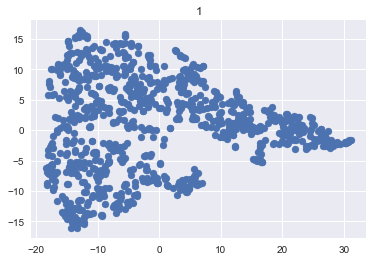

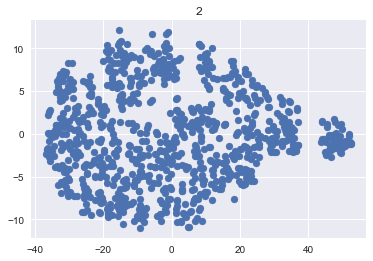

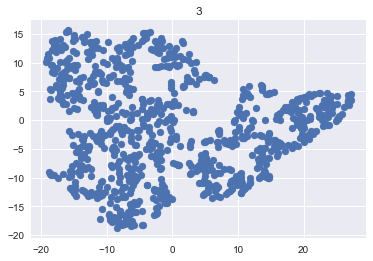

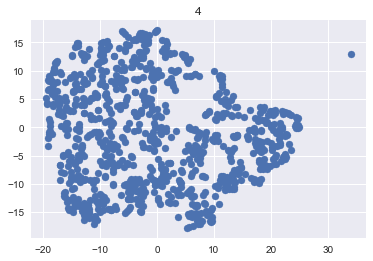

In [51]:
for key in spaces.keys():
    X = df[spaces[key]]
    print ('Feature Space No. {}'.format(key[2]))
    plot_tsne_scatter(X,filename='feature_space_{}'.format(key[2]),title=key[2])
    

Each of those spaces definitely feature some good-looking clusters! Number two looks the best to me - let's explore it a little deeper:

In [69]:
X = df[spaces['fs2']]
X.columns

Index([u'DRtg', u'eFG%', u'pass', u'FT%', u'tchs', u'3PA', u'STL', u'dfgm',
       u'3PAr', u'TRB', u'BLK', u'OBPM', u'FT'],
      dtype='object')

Let's look at some pairwise plots for these features:

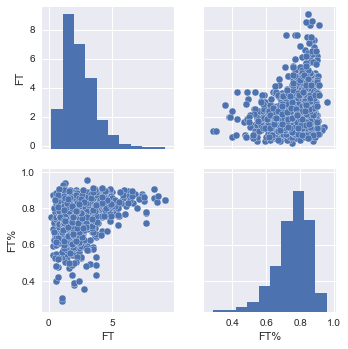

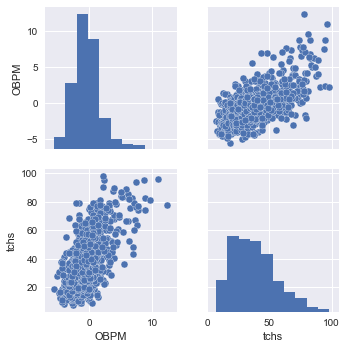

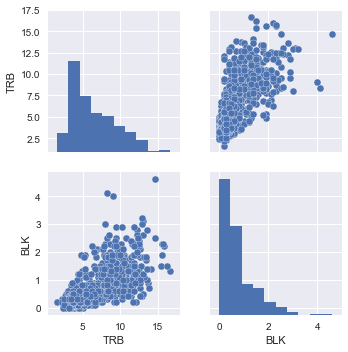

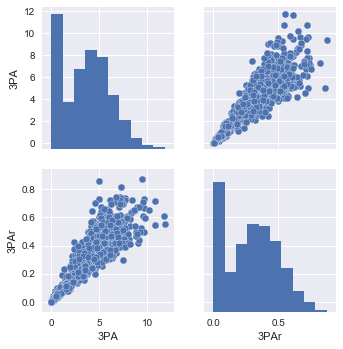

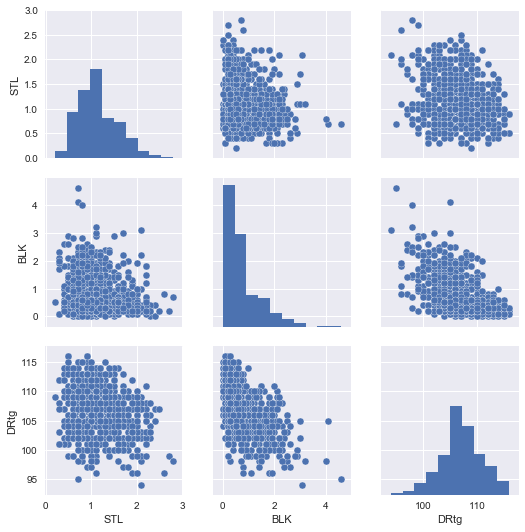

In [79]:
# Do any features seem like they might be collinear...?
sns.pairplot(X[['FT','FT%']])
sns.pairplot(X[['OBPM','tchs']])
sns.pairplot(X[['TRB','BLK']])
sns.pairplot(X[['3PA','3PAr']])
sns.pairplot(X[['STL','BLK','DRtg']])

## Let's try some simple clustering techniques on our subspaces!

In [83]:
damping_list = np.linspace(0.5,0.99,10)
def cluster(X):
    for d in damping_list:
        affinity = AffinityPropagation(damping=d)
        affinity.fit(X)
        try:
            print('{} | {}'.format(d,silhouette_score(X,affinity.labels_)))
        except:
            continue
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster(X)
    print('---')

fs1
0.5 | 0.18559179087
0.554444444444 | 0.192571657695
0.608888888889 | 0.182586785646
0.663333333333 | 0.188425446411
0.717777777778 | 0.187947340317
0.772222222222 | 0.188435979657
0.826666666667 | 0.186108279625
0.881111111111 | 0.185127771024
0.935555555556 | 0.185127771024
0.99 | 0.195580338154
---
fs2
0.5 | 0.170276401652
0.554444444444 | 0.176406449527
0.608888888889 | 0.176679300389
0.663333333333 | 0.171206775794
0.717777777778 | 0.170028012277
0.772222222222 | 0.171055809568
0.826666666667 | 0.172985513738
0.881111111111 | 0.172985513738
0.935555555556 | 0.169553743425
0.99 | 0.497763549247
---
fs3
0.5 | 0.201130080014
0.554444444444 | 0.20263834463
0.608888888889 | 0.19906555986
0.663333333333 | 0.203194460022
0.717777777778 | 0.201542173315
0.772222222222 | 0.196603495232
0.826666666667 | 0.201241519808
0.881111111111 | 0.202919039059
0.935555555556 | 0.199883642262
0.99 | 0.328149557039
---
fs4
0.5 | 0.16364651303
0.554444444444 | 0.16348328647
0.608888888889 | 0.15968404

That silhouette spike in fs2 with damping = 0.99 seems worth checking out...

In [99]:
affinity = AffinityPropagation(damping=0.99)
X = df[spaces['fs2']]
affinity.fit(X)
X['label'] = affinity.labels_

/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [100]:
# Let's see the distribution of our cluster labels:
X['label'].value_counts()

0    549
1    362
Name: label, dtype: int64

In [219]:
# That's...not quite what we were looking for.  Let's try something similar but only keep the models that meet  
# a certain condition

damping_list = np.linspace(0.5,0.99,10)
def cluster_exclusive(X):
    for d in damping_list:
        affinity = AffinityPropagation(damping=d,preference=-350)
        affinity.fit(X)
        X['label'] = affinity.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            try:
                print('{} | {} | {}'.format(d,len(X['label'].value_counts()),silhouette_score(X,affinity.labels_)))
            except:
                continue
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_exclusive(X)
    print('---')
    
# This snippet iterates through each feature subspace, and fits the space, iteratively, with various affinity
# propagation models.  It will print a damping parameter in a given subspace only if Nikola Jokic and Marc Gasol 
# are placed in the same cluster.  These are two very similar players, and this is a nice way of checking if a model 
# is working at least a little bit

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5 | 14 | 0.361618858647
0.554444444444 | 14 | 0.371895183757
0.608888888889 | 14 | 0.388429343144
0.663333333333 | 15 | 0.390216726939
0.717777777778 | 15 | 0.390308193288
0.772222222222 | 15 | 0.389359609664
0.826666666667 | 15 | 0.389359609664
0.881111111111 | 15 | 0.389359609664
0.935555555556 | 15 | 0.389359609664
0.99 | 4 | 0.122996494139
---
fs2
0.5 | 36 | 0.282258157511
0.554444444444 | 37 | 0.277911122547
0.608888888889 | 37 | 0.276489599844
0.663333333333 | 38 | 0.286345387912
0.717777777778 | 38 | 0.2864349484
0.772222222222 | 38 | 0.2864349484
0.826666666667 | 38 | 0.2864349484
0.881111111111 | 38 | 0.2864349484
0.935555555556 | 38 | 0.2864349484
0.99 | 14 | 0.206026703225
---
fs3
0.5 | 24 | 0.375911165706
0.554444444444 | 24 | 0.362062859075
0.608888888889 | 25 | 0.393364098216
0.663333333333 | 25 | 0.395305371671
0.717777777778 | 25 | 0.394644186248
0.772222222222 | 25 | 0.394644186248
0.826666666667 | 25 | 0.394644186248
0.881111111111 | 25 | 0.394644186248
0.9355555555

In [220]:
X = df[spaces['fs1']]
aff = AffinityPropagation(damping=0.75,preference=-350)
aff.fit(X)

X['label'] = aff.labels_


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [226]:
X['label'].value_counts()
# X.loc['Nikola Jokic/2016-17']
X[X['label'] == 5]

FG%  TOV    3P%  DBPM  3PA  BLK  STL  STL%  \
player_year                                                                   
Marc Gasol/2015-16             0.464  2.4  0.667   1.7  0.1  1.4  1.0   1.4   
Zaza Pachulia/2014-15          0.454  2.8  0.000   2.2  0.1  0.4  1.7   2.4   
Andrew Bogut/2014-15           0.563  2.4  0.000   5.5  0.0  2.6  0.9   1.2   
Nikola Jokic/2015-16           0.512  2.2  0.333   2.2  1.7  1.0  1.6   2.3   
Greg Monroe/2016-17            0.533  2.8  0.000   1.5  0.1  0.8  1.8   2.6   
Jared Sullinger/2015-16        0.435  1.9  0.282   2.3  1.9  0.9  1.4   1.9   
Pau Gasol/2016-17              0.502  1.8  0.538   2.8  2.3  1.5  0.5   0.8   
Nikola Vucevic/2015-16         0.510  2.2  0.222   1.1  0.2  1.2  0.9   1.3   
Josh Smith/2014-15             0.419  3.2  0.316   2.6  3.6  1.8  1.4   1.9   
Julius Randle/2016-17          0.488  2.9  0.270   0.7  1.1  0.6  0.8   1.1   
Tim Duncan/2014-15             0.512  2.1  0.286   4.7  0.1  2.4  1.0   1.4   
DeMarcus Cousins/2015-16       0.451  4.0  0.333   1.6  3.4  1.5  1.6   2.2   
Nikola Vucevic/2016-17         0.468  1.9  0.307   2.4  1.2  1.2  1.3   1.8   
Mason Plumlee/2015-16          0.516  2.7  0.000   3.0  0.1  1.5  1.2   1.6   
Mason Plumlee/2016-17          0.536  2.3  0.000   2.6  0.1  1.5  1.2   1.6   
Al Horford/2015-16             0.505  1.5  0.344   2.6  3.5  1.7  0.9   1.3   
DeMarcus Cousins/2014-15       0.467  4.5  0.250   3.3  0.1  1.8  1.6   2.3   
Al Horford/2014-15             0.538  1.6  0.306   2.5  0.6  1.5  1.1   1.5   
Marc Gasol/2014-15             0.494  2.4  0.176   3.5  0.2  1.8  0.9   1.4   
Draymond Green/2014-15         0.443  1.9  0.337   4.0  4.8  1.4  1.8   2.4   
Pau Gasol/2014-15              0.494  2.1  0.462   2.1  0.3  2.0  0.3   0.5   
Paul Millsap/2014-15           0.476  2.5  0.356   2.6  3.3  1.0  2.0   2.8   
Paul Millsap/2015-16           0.470  2.6  0.319   4.2  3.2  1.9  2.0   2.7   
Paul Millsap/2016-17           0.442  2.4  0.311   2.1  3.7  1.0  1.4   1.9   
Giannis Antetokounmpo/2015-16  0.506  2.7  0.257   1.5  1.4  1.4  1.2   1.7   
KarlAnthony Towns/2016-17      0.542  2.5  0.367   0.3  3.3  1.2  0.7   1.0   

                                 2P%      dfgm       dfga   3PAr  AST%    FT%  \
player_year                                                                     
Marc Gasol/2015-16             0.463  2.000000   4.390244  0.004  18.9  0.829   
Zaza Pachulia/2014-15          0.456  2.772727   5.147727  0.006  16.2  0.788   
Andrew Bogut/2014-15           0.563  2.910112   7.033708  0.000  15.4  0.524   
Nikola Jokic/2015-16           0.541  2.578313   5.144578  0.140  18.1  0.811   
Greg Monroe/2016-17            0.536  2.750000   5.011364  0.006  17.3  0.741   
Jared Sullinger/2015-16        0.458  2.793103   5.149425  0.128  15.5  0.640   
Pau Gasol/2016-17              0.494  2.975309   6.259259  0.172  14.7  0.707   
Nikola Vucevic/2015-16         0.512  3.367089   6.278481  0.009  15.9  0.753   
Josh Smith/2014-15             0.451  2.990000   6.510000  0.231  20.5  0.498   
Julius Randle/2016-17          0.507  2.772152   4.670886  0.082  19.3  0.723   
Tim Duncan/2014-15             0.514  4.089888   8.730337  0.009  16.8  0.740   
DeMarcus Cousins/2015-16       0.473  3.480519   7.025974  0.158  17.0  0.718   
Nikola Vucevic/2016-17         0.481  3.886076   7.151899  0.073  16.9  0.669   
Mason Plumlee/2015-16          0.520  4.180851   7.872340  0.008  16.2  0.642   
Mason Plumlee/2016-17          0.541  3.450000   6.962500  0.010  19.8  0.580   
Al Horford/2015-16             0.557  3.476636   7.093458  0.244  16.7  0.798   
DeMarcus Cousins/2014-15       0.469  3.825397   8.142857  0.008  20.4  0.782   
Al Horford/2014-15             0.547  3.469388   6.979592  0.037  18.6  0.759   
Marc Gasol/2014-15             0.500  3.731183   7.440860  0.016  19.7  0.795   
Draymond Green/2014-15         0.523  3.039604   6.554455  0.430  16.1  0.660   
Pau Gasol/2014-15              0.495  

Those all look like pretty high cluster counts, let's try another unsupervised method - DBSCAN:

In [108]:
eps_list = np.linspace(0.5,5,15)
def cluster_dbscan(X):
    for epsilon in eps_list:
        db = DBSCAN(eps=epsilon)
        db.fit(X)
        X['label'] = db.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} || {}'.format(epsilon,len(X['label'].value_counts())))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_dbscan(X)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5 || 1
0.821428571429 || 1
1.14285714286 || 8
1.46428571429 || 28
1.78571428571 || 35
2.10714285714 || 41
2.42857142857 || 44
2.75 || 45
5.0 || 3
---
fs2
0.5 || 1
0.821428571429 || 1
1.14285714286 || 1
1.46428571429 || 1
1.78571428571 || 1
2.10714285714 || 1
2.42857142857 || 6
2.75 || 10
3.07142857143 || 20
3.39285714286 || 34
3.71428571429 || 44
4.03571428571 || 49
---
fs3
0.5 || 1
0.821428571429 || 1
1.14285714286 || 3
1.46428571429 || 17
1.78571428571 || 28
2.10714285714 || 38
2.42857142857 || 50
2.75 || 52
3.07142857143 || 54
3.39285714286 || 53
3.71428571429 || 43
4.03571428571 || 33
4.35714285714 || 21
4.67857142857 || 11
---
fs4
0.5 || 1
0.821428571429 || 1
1.14285714286 || 1
1.46428571429 || 1
1.78571428571 || 1
2.10714285714 || 2
2.42857142857 || 7
2.75 || 12
3.07142857143 || 17
3.39285714286 || 24
3.71428571429 || 27
4.03571428571 || 31
4.35714285714 || 27
4.67857142857 || 25
5.0 || 17
---


For each of our subspaces, it looks like we can roughly control our number of clusters by keeping the epsilon value in a certain range...let's customize those ranges, and see what our clusters end up looking like:

In [110]:
fs1_eps = np.linspace(1.15,1.4,8)
fs2_eps = np.linspace(2.75,3.1,8)
fs3_eps = np.linspace(1.4,1.7,8)
fs4_eps = np.linspace(3,3.2,8)

eps_dict = {'fs1':fs1_eps,'fs2':fs2_eps,'fs3':fs3_eps,'fs4':fs4_eps}

eps_list = np.linspace(0.5,5,15)
def cluster_scan_interval(X,eps_list):
    for epsilon in eps_list:
        db = DBSCAN(eps=epsilon)
        db.fit(X)
        X['label'] = db.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} || {} || Silhouette Score: {}'.format(epsilon,len(X['label'].value_counts()),silhouette_score(X,db.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    eps_list = eps_dict[space]
    cluster_scan_interval(X,eps_list)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.15 || 8 || Silhouette Score: -0.407433510315
1.18571428571 || 10 || Silhouette Score: -0.349584108699
1.22142857143 || 11 || Silhouette Score: -0.331029087101
1.25714285714 || 15 || Silhouette Score: -0.286278534275
1.29285714286 || 17 || Silhouette Score: -0.277823784557
1.32857142857 || 24 || Silhouette Score: -0.214877664672
1.36428571429 || 27 || Silhouette Score: -0.218971590429
1.4 || 30 || Silhouette Score: -0.177794760676
---
fs2
2.75 || 9 || Silhouette Score: -0.396378927474
2.8 || 9 || Silhouette Score: -0.398460418135
2.85 || 10 || Silhouette Score: -0.393973828623
2.9 || 12 || Silhouette Score: -0.445878394967
2.95 || 17 || Silhouette Score: -0.376397300318
3.0 || 18 || Silhouette Score: -0.371264761585
3.05 || 18 || Silhouette Score: -0.371264761585
3.1 || 22 || Silhouette Score: -0.356097318188
---
fs3
1.4 || 11 || Silhouette Score: -0.314601760589
1.44285714286 || 15 || Silhouette Score: -0.321421933909
1.48571428571 || 16 || Silhouette Score: -0.327416257811
1.5285714

Those silhouette scores are notably poor, let's see how the clusters look on the basketball side of things...

In [114]:
# We'll use fs2 as an example again - with epsilon=2.92
db = DBSCAN(eps=2.92)
X = df[spaces['fs2']]
db.fit(X)
X['label'] = db.labels_
X.head()

/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DRtg   eFG%      pass    FT%       tchs  3PA  STL  \
player_year                                                                  
Nick Collison/2015-16     107  0.459  5.744681  0.697   7.333333  0.1  0.8   
Jimmer Fredette/2014-15   111  0.407  5.918605  0.956   8.779070  3.4  1.1   
Brandon Bass/2016-17      109  0.578  7.147727  0.875  10.397727  0.2  0.9   
Tyler Zeller/2016-17      109  0.494  7.863636  0.564  10.795455  0.1  0.5   
Justin Holiday/2014-15    101  0.462  5.940594  0.822   8.861386  6.0  2.2   

                             dfgm   3PAr  TRB  BLK  OBPM   FT  label  
player_year                                                           
Nick Collison/2015-16    0.468085  0.018  8.8  0.8  -2.5  1.2     -1  
Jimmer Fredette/2014-15  0.127907  0.289  2.8  0.1  -2.6  3.0     -1  
Brandon Bass/2016-17     0.420455  0.016  8.0  0.7   0.1  4.8     -1  
Tyler Zeller/2016-17     0.772727  0.006  8.5  1.4  -3.2  1.5     -1  
Justin Holiday/2014-15   0.247525  0.464  4.0  0.7  -1.4  2.0     -1

In [115]:
X['label'].value_counts()

-1    781
 0     55
 3     24
 2     15
 9      7
 1      6
 4      6
 8      5
 5      5
 6      4
 7      3
Name: label, dtype: int64

Uh Oh... -1 means a record is too noisy for DBSCAN to label - let's move on to something else.

In [122]:
# Agglomerative Clustering
# In agglomerative clustering, at the beginning of runtime, each record constitutes a cluster; the algorithm then 
# iteratively merges pairs of clusters until arriving at a specified k clusters.

cluster_list = range(5,20)
def cluster_agglomerative(X,cluster_list):
    for k in cluster_list:
        agg = AgglomerativeClustering(n_clusters=k,affinity='cosine',linkage='average')
        agg.fit(X)
        X['label'] = agg.labels_
        if X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} clusters || Silhouette Score: {}'.format(k,silhouette_score(X,agg.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_agglomerative(X,cluster_list)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5 clusters || Silhouette Score: 0.00233293011511
6 clusters || Silhouette Score: -0.011039270186
7 clusters || Silhouette Score: -0.00307478155147
8 clusters || Silhouette Score: -0.00322161906276
9 clusters || Silhouette Score: 0.112764843027
10 clusters || Silhouette Score: 0.0504255183163
11 clusters || Silhouette Score: 0.121318062622
12 clusters || Silhouette Score: 0.103915665786
13 clusters || Silhouette Score: 0.166352330233
14 clusters || Silhouette Score: 0.140229108639
15 clusters || Silhouette Score: 0.108901825203
16 clusters || Silhouette Score: 0.135450653771
17 clusters || Silhouette Score: 0.155460672484
18 clusters || Silhouette Score: 0.110293127295
19 clusters || Silhouette Score: 0.214322129259
---
fs2
5 clusters || Silhouette Score: 0.29969339033
6 clusters || Silhouette Score: 0.277395851916
7 clusters || Silhouette Score: 0.271470611371
8 clusters || Silhouette Score: 0.275283634007
9 clusters || Silhouette Score: 0.282226945108
10 clusters || Silhouette Score: 

## A Couple Things to Notice:
1. The 3rd and 4th feature spaces only managed to place Jokic and Gasol in the same cluster once - those both warrant further investigation, but that's perhaps a sign that a final space looking more like some combination of feature spaces 1 and 2 will give us the clusters we're looking for.
  
2. Barring the n_clusters parameter, these scores came from largely out-of-box modelling - there's plenty of room for improvement!

3. While scores held fairly constant through the entirety of fs2's iteration, they didn't jump above 0.1 on fs1 until k > 10, perhaps an indicator that we should be looking for a similar number of clusters.

With number 3 in mind, let's try some more algorithms, starting with Mean-shift:

In [300]:
def cluster_meanshift(X):
    mean = MeanShift(bandwidth=20)
    mean.fit(X)
    X['label'] = mean.labels_
    try:
        score = silhouette_score(X,mean.labels_)
    except:
        print("No silhouette score - only 1 label found")
        return
    if score > 0.2 and X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
        print('{} clusters || Calinski-Harbaz: {}'.format(len(np.unique(mean.labels_)),silhouette_score(X,km.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_meanshift(X)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No silhouette score - only 1 label found
---
fs2
No silhouette score - only 1 label found
---
fs3
No silhouette score - only 1 label found
---
fs4
No silhouette score - only 1 label found
---


In [132]:
# Let's do a simple count of the different stats in spaces fs1 and fs2 and print the stats that came up in both:
count1_plus_2 = dict(Counter(spaces['fs1']+spaces['fs2']))
print(count1_plus_2)

for (key,value) in count1_plus_2.items():
    if value == 2:
        print (key)

{'STL%': 1, 'dfgm': 2, 'FT': 1, 'STL': 2, 'TRB': 1, 'TOV': 1, 'AST%': 1, 'dfga': 1, 'eFG%': 1, 'BLK': 2, 'pass': 1, 'FG%': 1, 'OBPM': 1, '3PA': 2, 'DBPM': 1, 'DRtg': 1, 'tchs': 1, 'FT%': 2, '3PAr': 2, '2P%': 1, '3P%': 1}
dfgm
STL
BLK
3PA
FT%
3PAr


In [125]:
# Let's look exclusively for models that will outperform what we've already seen agglomerative clustering do

cluster_list = range(5,20)
def cluster_kmeans(X,cluster_list):
    for k in cluster_list:
        km = KMeans(n_clusters=k,max_iter=500,algorithm='full',precompute_distances=True)
        km.fit(X)
        X['label'] = km.labels_
        if silhouette_score(X,km.labels_) > 0.2 and X.loc['Nikola Jokic/2016-17']['label'] == X.loc['Marc Gasol/2016-17']['label']:
            print('{} clusters || Silhouette Score: {}'.format(k,silhouette_score(X,km.labels_)))
for space in spaces.keys():
    print(space)
    X = df[spaces[space]]
    cluster_kmeans(X,cluster_list)
    print('---')

fs1


/Users/robertcorboy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5 clusters || Silhouette Score: 0.358382833744
6 clusters || Silhouette Score: 0.366664993969
10 clusters || Silhouette Score: 0.422942280235
11 clusters || Silhouette Score: 0.369830908301
12 clusters || Silhouette Score: 0.359236192954
13 clusters || Silhouette Score: 0.403639986858
14 clusters || Silhouette Score: 0.401916918912
15 clusters || Silhouette Score: 0.422962011563
16 clusters || Silhouette Score: 0.411985657462
17 clusters || Silhouette Score: 0.41006260698
18 clusters || Silhouette Score: 0.437356367015
19 clusters || Silhouette Score: 0.408000023944
---
fs2
5 clusters || Silhouette Score: 0.330871144693
6 clusters || Silhouette Score: 0.317021659894
7 clusters || Silhouette Score: 0.280733439711
8 clusters || Silhouette Score: 0.28656066641
9 clusters || Silhouette Score: 0.290901248724
10 clusters || Silhouette Score: 0.294368028273
11 clusters || Silhouette Score: 0.303957946238
12 clusters || Silhouette Score: 0.319255152838
13 clusters || Silhouette Score: 0.276160

fs1 did pretty well with very little parameterization, let's dig into it a little bit:

In [304]:
# let's fit the model 1000 times, and see which number of clusters ends up giving us the best scores

# caution - this is another one that takes a while to run!
X = df[spaces['fs1']]


scores_dict = {n:0 for n in range(5,20)}
calinski_dict = {n:0 for n in range(5,20)}
for i in range(1000):
    for k in cluster_list:
        km = KMeans(n_clusters=k,max_iter=500,algorithm='full',precompute_distances=True)
        km.fit(X)
        score = silhouette_score(X,km.labels_)
        calinski_score = calinski_harabaz_score(X,km.labels_)
        
        
        scores_dict[k] += round(score,4)
        calinski_dict[k] += round(calinski_score,4)
    if i%25 == 0:
        print(i)
        print(scores_dict)
        print(calinski_dict)
        print("---")

0
{5: 0.3202, 6: 0.3075, 7: 0.3086, 8: 0.2789, 9: 0.2652, 10: 0.2724, 11: 0.2638, 12: 0.2515, 13: 0.2315, 14: 0.2319, 15: 0.2357, 16: 0.2327, 17: 0.2353, 18: 0.2286, 19: 0.2144}
{5: 1063.3032, 6: 987.5629, 7: 947.388, 8: 909.4423, 9: 878.0616, 10: 852.7592, 11: 834.0089, 12: 793.5503, 13: 763.7002, 14: 738.6079, 15: 720.3113, 16: 696.6092, 17: 679.4268, 18: 655.6765, 19: 644.2996}
---
25
{5: 8.360999999999997, 6: 8.156000000000002, 7: 8.077900000000001, 8: 7.2948, 9: 6.909799999999999, 10: 6.8396, 11: 6.8045, 12: 6.5687, 13: 6.3588, 14: 6.3748999999999985, 15: 6.1319, 16: 6.0781, 17: 5.981600000000001, 18: 5.900599999999999, 19: 5.7812}
{5: 27675.558600000004, 6: 25668.797099999992, 7: 24636.9649, 8: 23589.9509, 9: 22777.089099999997, 10: 22194.5897, 11: 21659.8846, 12: 20701.564700000003, 13: 19908.432500000003, 14: 19272.5992, 15: 18667.740800000003, 16: 18135.5259, 17: 17667.675300000003, 18: 17202.687799999996, 19: 16770.458399999996}
---
50
{5: 16.407299999999996, 6: 15.9628000000

KeyboardInterrupt: 

In [128]:
scores_dict

{5: 321.61125115207255,
 6: 313.57783783000099,
 7: 310.94032159382903,
 8: 281.62822549309334,
 9: 266.3275154012411,
 10: 261.91144783922914,
 11: 262.03521464408965,
 12: 252.75335743525187,
 13: 246.79502718729049,
 14: 242.92946081109366,
 15: 237.65792859079667,
 16: 233.8986367358072,
 17: 230.70564197961903,
 18: 226.99030002025054,
 19: 223.63308979042216}

In [263]:
feature_space_dict = get_feature_spaces(50,10)
print (feature_space_dict)

Creating subspace 0
0
Creating subspace 1
0
Creating subspace 2
0
Creating subspace 3
0
Creating subspace 4
0
Creating subspace 5
0
Creating subspace 6
0
Creating subspace 7
0
Creating subspace 8
0
Creating subspace 9
0
Creating subspace 10
0
Creating subspace 11
0
Creating subspace 12
0
Creating subspace 13
0
Creating subspace 14
0
Creating subspace 15
0
Creating subspace 16
0
Creating subspace 17
0
Creating subspace 18
0
Creating subspace 19
0
Creating subspace 20
0
Creating subspace 21
0
Creating subspace 22
0
Creating subspace 23
0
Creating subspace 24
0
Creating subspace 25
0
Creating subspace 26
0
Creating subspace 27
0
Creating subspace 28
0
Creating subspace 29
0
Creating subspace 30
0
Creating subspace 31
0
Creating subspace 32
0
Creating subspace 33
0
Creating subspace 34
0
Creating subspace 35
0
Creating subspace 36
0
Creating subspace 37
0
Creating subspace 38
0
Creating subspace 39
0
Creating subspace 40
0
Creating subspace 41
0
Creating subspace 42
0
Creating subspace 43


In [269]:
feature_space_dict[0]

(['FT',
  'TOV%',
  'dfgm',
  'pass',
  'ftast',
  'MP_x',
  'STL',
  '3P%',
  'BPM',
  'AST',
  'TRB',
  'PER',
  'ORB%',
  'PTS',
  'TOV',
  '3PAr',
  'eFG%',
  'BLK%',
  'FG%',
  'DRB%',
  'STL%',
  'DRB',
  'dfga'],
 0.41984685287166862)

In [277]:
features_list = []
for feature in feature_space_dict.keys():
    features_list += (feature_space_dict[feature][0])
Counter(features_list)

Counter({'2P': 20,
         '2P%': 26,
         '2PA': 25,
         '3P': 27,
         '3P%': 24,
         '3PA': 33,
         '3PAr': 27,
         'AST': 27,
         'AST%': 25,
         'BLK': 27,
         'BLK%': 18,
         'BPM': 24,
         'DBPM': 26,
         'DRB': 26,
         'DRB%': 20,
         'DRtg': 27,
         'DWS': 24,
         'FG': 28,
         'FG%': 21,
         'FGA': 23,
         'FT': 31,
         'FT%': 23,
         'FTA': 28,
         'FTr': 24,
         'MP_x': 30,
         'OBPM': 21,
         'ORB': 29,
         'ORB%': 31,
         'ORtg': 23,
         'OWS': 27,
         'PER': 28,
         'PF': 26,
         'PTS': 18,
         'STL': 25,
         'STL%': 22,
         'TOV': 25,
         'TOV%': 22,
         'TRB': 19,
         'TRB%': 26,
         'TS%_x': 27,
         'USG%': 22,
         'VORP': 26,
         'WS': 25,
         'WS/48': 27,
         'dfga': 26,
         'dfgm': 23,
         'dist': 30,
         'eFG%': 28,
         'ftast': 21,
 

In [273]:
feature_space_dict

{0: (['FT',
   'TOV%',
   'dfgm',
   'pass',
   'ftast',
   'MP_x',
   'STL',
   '3P%',
   'BPM',
   'AST',
   'TRB',
   'PER',
   'ORB%',
   'PTS',
   'TOV',
   '3PAr',
   'eFG%',
   'BLK%',
   'FG%',
   'DRB%',
   'STL%',
   'DRB',
   'dfga'],
  0.41984685287166862),
 1: (['WS/48',
   'FTr',
   'TS%_x',
   'ORB%',
   'pass',
   'sast',
   '2P%',
   'MP_x',
   'STL',
   'WS',
   'AST',
   'OWS',
   'eFG%'],
  0.44875929053869196),
 2: (['3P',
   'DRtg',
   'tchs',
   'spd',
   '2P%',
   'DBPM',
   'STL%',
   'BLK',
   'BPM',
   '3PAr',
   'PER',
   'FGA',
   '3PA',
   'WS',
   'dfga',
   'eFG%',
   'FTA'],
  0.45415929402631144),
 3: (['3P%',
   'USG%',
   'TRB%',
   'FGA',
   'DWS',
   'FG',
   '2PA',
   'dist',
   'MP_x',
   'TS%_x',
   'ORB%',
   'OWS',
   'FTA',
   'VORP',
   'eFG%',
   '3PA',
   'FTr',
   'PER',
   'tchs',
   'WS/48',
   'spd',
   'PTS',
   '3P',
   'FT%',
   'DBPM',
   'DRtg',
   'STL%',
   'TOV',
   'TOV%',
   'ORB',
   'FT',
   '2P',
   'AST%'],
  0.4155554794

In [311]:
error_dict = {n:0 for n in range(5,20)}
scores_dict = {n:0 for n in range(5,20)}
calinski_dict = {n:0 for n in range(5,20)}

scores = pd.DataFrame(columns=['k','error','silhouette','calinski'])
dfidx = 0
for i in range(100):
    for k in cluster_list:
        km = KMeans(n_clusters=k,max_iter=500,algorithm='full',precompute_distances=True)
        km.fit(X)
        score = silhouette_score(X,km.labels_)
        calinski_score = calinski_harabaz_score(X,km.labels_)
        error = km.score(X)
        
        record_dict = {'k':k,'error':error,'silhouette':score,'calinski':calinski_score}
        scores.loc[dfidx] = record_dict
        dfidx += 1
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


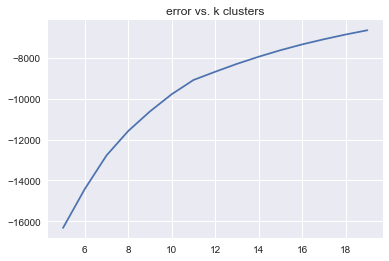

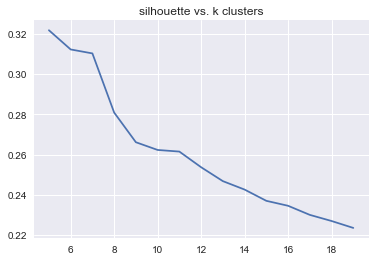

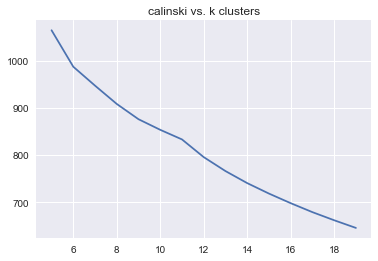

In [328]:
sns.set_style("darkgrid")
metric_list = ['error','silhouette','calinski']

averages = scores.groupby('k').mean()
for metric in metric_list:
    plt.plot(averages.index.values,averages[metric])
    plt.title("{} vs. k clusters".format(metric))
    plt.show()


In [334]:
# Let's try with PCA now!

pca = PCA(n_components=2,svd_solver='full')
km = KMeans(n_clusters=k,max_iter=500,algorithm='full',precompute_distances=True)


scores = pd.DataFrame(columns=['k','error','silhouette','calinski'])
dfidx = 0
for i in range(100):
    for k in cluster_list:
        reduced = pca.fit_transform(X)
        km.fit(reduced)
        
        score = silhouette_score(reduced,km.labels_)
        calinski_score = calinski_harabaz_score(reduced,km.labels_)
        error = km.score(reduced)
        
        record_dict = {'k':k,'error':error,'silhouette':score,'calinski':calinski_score}
        scores.loc[dfidx] = record_dict
        dfidx += 1
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


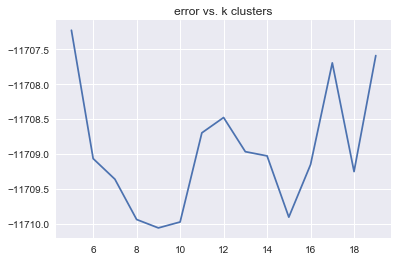

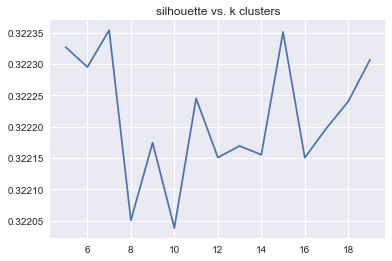

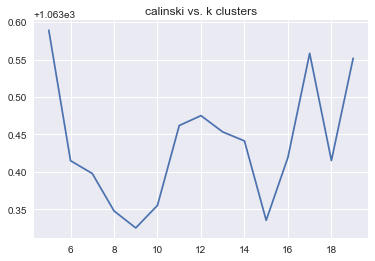

In [333]:
sns.set_style("darkgrid")
metric_list = ['error','silhouette','calinski']

averages = scores.groupby('k').mean()
for metric in metric_list:
    plt.plot(averages.index.values,averages[metric])
    plt.title("{} vs. k clusters".format(metric))
    plt.show()

Those graphs still aren't inspiring too much confidence - let's try something a little more robust: Gaussian Mixed Models

In [337]:
scores_gmm = pd.DataFrame(columns=['k','error','silhouette','calinski'])


dfidx = 0
for i in range(100):
    for k in cluster_list:
        gmm = GaussianMixture(n_components=k,n_init=1)
#         reduced = pca.fit_transform(X)
        gmm.fit(X)
        pred_labels = gmm.predict(X)
        
        score = silhouette_score(X,pred_labels)
        calinski_score = calinski_harabaz_score(X,pred_labels)
        error = gmm.score(X)
        
        record_dict = {'k':k,'error':error,'silhouette':score,'calinski':calinski_score}
        scores_gmm.loc[dfidx] = record_dict
        dfidx += 1
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


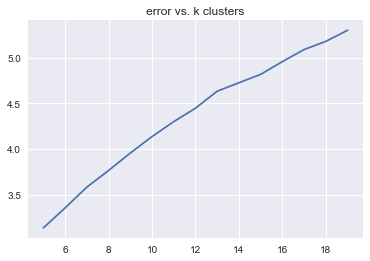

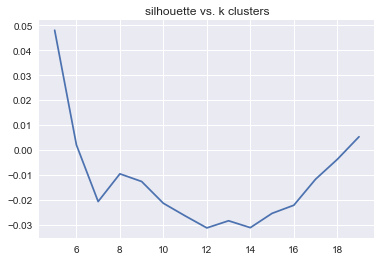

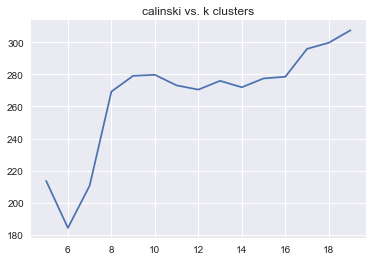

In [338]:
sns.set_style("darkgrid")
metric_list = ['error','silhouette','calinski']

averages = scores_gmm.groupby('k').mean()
for metric in metric_list:
    plt.plot(averages.index.values,averages[metric])
    plt.title("{} vs. k clusters".format(metric))
    plt.show()

In [372]:
# Again, let's initialize the data with PCA!
scores_gmm_pca = pd.DataFrame(columns=['k','error','silhouette','calinski'])
pca = PCA(n_components=2,svd_solver='full')

X = df[spaces['fs4']]
cluster_list = range(5,20)
dfidx = 0
for i in range(100):
    for k in cluster_list:
        gmm = GaussianMixture(n_components=k,n_init=1,covariance_type='tied')
        reduced = pca.fit_transform(X)
        gmm.fit(reduced)
        pred_labels = gmm.predict(reduced)
        
        score = silhouette_score(reduced,pred_labels)
        calinski_score = calinski_harabaz_score(reduced,pred_labels)
        error = gmm.score(reduced)
        
        record_dict = {'k':k,'error':error,'silhouette':score,'calinski':calinski_score}
        scores_gmm_pca.loc[dfidx] = record_dict
        dfidx += 1
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


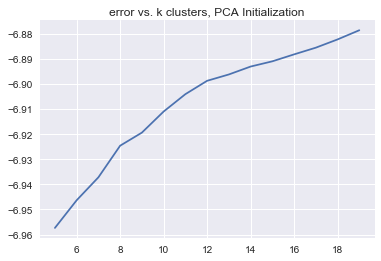

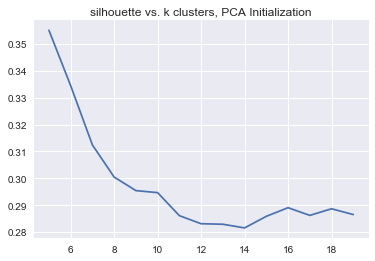

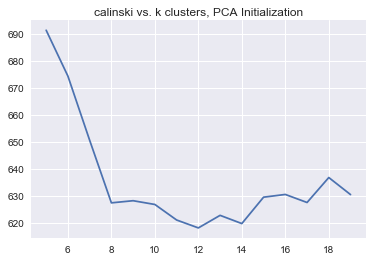

In [373]:
sns.set_style("darkgrid")
metric_list = ['error','silhouette','calinski']

averages = scores_gmm_pca.groupby('k').mean()
for metric in metric_list:
    plt.plot(averages.index.values,averages[metric])
    plt.title("{} vs. k clusters, PCA Initialization".format(metric))
    plt.show()